In [1]:
import sys
sys.path.append('../src')
from data import get_documents_list, get_cleaned_dataframe_with_topics
from models import classification, get_embedding_model, get_BERTopic_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


loaded spacy language model: de_core_news_sm
loaded spacy language model: en_core_web_sm


load the preprocessed texts in all languages into a dataframe

In [2]:
df = get_cleaned_dataframe_with_topics()

Decide what types of documents you want to train your embedding model on

In [3]:
documents = get_documents_list('cleaned_texts_topics')

Document_list: [['Abel', 'Ehrlich', '3.', 'September', '1915', 'Cranz', 'Ostpreußen', '30.', 'Oktober', '2003', 'Tel', 'Aviv', 'israelisch', 'Komponist', 'ehrlich', 'aufwachsen', 'deutsch', 'jüdisch', 'Familie', 'fliehen', 'Abitur', 'Königsberg', '1934', 'Jugoslawien', 'studieren', 'Musikakademie', 'Zagreb', 'Komposition', 'Violin', 'Vaclav', 'Huml', '1938', 'emigrieren', 'Albanien', 'damalig', 'Palästina', 'ab', '1939', 'studieren', 'Konservatorium', 'Jerusalem', 'Emil', 'Hauser', 'Tzvi', 'Rothenberg', 'Solomon', 'Rosowski', 'unterrichten', 'danach', 'verschieden', 'Musikakademi', 'Jerusalem', 'Tel', 'Aviv', 'darunter', '1953', '1967', 'Kibbuzim-Hochschule', 'Oranim', '1972', 'Professor', 'damalig', 'Rubin-Akademie', 'Tel', 'Aviv', '1991', 'Bar-Ilan-Universität', 'lehren', 'komponieren', '3450', 'Werk', 'darunter', 'Oper', 'Oratorie', 'sowie', 'Chor', 'Solovokalmusik', 'Orchesterwerk', 'Ballette', 'Schauspiel', 'Kammermusik', 'Elektroakustische', 'Musik', 'berühmt', 'Komposition', 'Ba

## Word2Vec & fastText
### Parameters:
- vector_size - vector size
- window - num of words before and after the focus word considered as context for the word
- min_count - the number of times a word must appear in our corpus in order to create a word vector.

Train a Word2Vec model with the train set

For multilingual fastText Model first train monolingual fastText models (use parameter method="fastText"). 
Then use muse library to align the embeddings: https://github.com/facebookresearch/MUSE
The command could look like this: 

``` shell
python supervised.py --src_lang en --tgt_lang de --src_emb /Users/jessicahassibi/Bachelor-Thesis/models/classification/FastText/FastText_en_cleaned_texts.vec --tgt_emb /Users/jessicahassibi/Bachelor-Thesis/models/classification/FastText/FastText_de_cleaned_texts.vec --n_refinement 5 --dico_train default --cuda=False
```

Place the aligned vectors to /models/classification/FastText/aligned_embeddings and use code in next cell with method="muse" to combine those embeddings and get multilingual word vectors.

In [5]:
model, word_vectors = get_embedding_model(documents, method = "muse", text_type='cleaned_texts_topics')

In [6]:
# Similarity of vectors for a word (useful for bilingual)
word_vectors.similarity('composer', 'Komponist')

0.9259864

## Split data into train and test sets


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_texts'], df['label'] , test_size=0.2)

## Text Classification on manually trained Embedding model

### Create features from text for machine learning model.
Steps:
- Turn words in texts into word vectors.

In [8]:
X_train_vect = classification.text2vec(X_train, word_vectors)
X_test_vect = classification.text2vec(X_test, word_vectors)

- Method 1: averaging word vectors for each text

In [9]:
X_train_vect_avg = classification.average_vector(X_train_vect)
X_test_vect_avg = classification.average_vector(X_test_vect)

- Method 2: max word vectors for each text
- Method 3: min word vectors for each text

### Classification reports:
- Recall = how many of this class where found over whole num of elements of this class
- Precision = how many correctly classified among that class
- Accuracy = num of correct predictions/ num of total predictions
- f1-score: harmonic mean between precision and recall
- support: num of occurrence of given class in dataset

- recall macro avg = (recall_class_1 + recall_class_0) / 2
- recall weighted avg = (support_class_0 * recall_class_0 + support_class_1 * recall_class_1) / (support_class_0 + support_class_1)
- scikit learn classification_report average parameter explanation:

-average=micro: compute f1 by considering total true positives, false negatives and false positives (no matter of the prediction for each label in the dataset) (= Accuracy?)

-average=macro: compute f1 for each label, and returns the average without considering the proportion for each label in the dataset. (treats all classes the same)

-average=weighted: compute f1 for each label, and returns the average considering the proportion for each label in the dataset.

-average=samples: compute f1 for each instance, and returns the average. Use it for multilabel classification.


Instantiate and fit a basic Random Forest model on top of the vectors

In [10]:
y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Random Forest")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "SVM")
classification.print_classification_report(y_test, y_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.99      0.82      0.89        88
    begnadet       0.06      0.50      0.11         2

    accuracy                           0.81        90
   macro avg       0.52      0.66      0.50        90
weighted avg       0.97      0.81      0.88        90

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.95      0.82      0.88        84
    begnadet       0.12      0.33      0.17         6

    accuracy                           0.79        90
   macro avg       0.53      0.58      0.53        90
weighted avg       0.89   

0    303
1     53
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

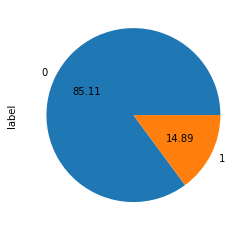

In [11]:
print(y_train.value_counts())
y_train.value_counts().plot.pie(autopct='%0.2f')

Highly Imbalanced Dataset!
Ideas:
- Undersampling: reduce majority class to make it equal to minority class
- Oversampling: increase minority class to make it equal to majority class through resampling
- K-fold cross validation

## Oversampling

In [12]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority")
X_train_2d = X_train.values.reshape(-1, 1) # puts each elem of array in own array
X_res, y_res = ros.fit_resample(X_train_2d, y_train)

0    303
1    303
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

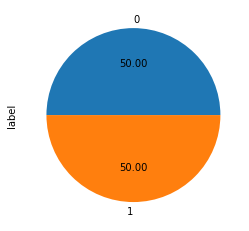

In [13]:
print(y_res.value_counts())
y_res.value_counts().plot.pie(autopct='%0.2f')

In [14]:
#X_res revert 2_dimensionality
X_res_1d = X_res.flatten()

# classification with resampled vectors
X_res_vect = classification.text2vec(X_res_1d, word_vectors)
X_res_vect_avg = classification.average_vector(X_res_vect)

In [15]:
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Random Forest")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "SVM")
classification.print_classification_report(y_test, y_res_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.96      0.80      0.88        87
    begnadet       0.00      0.00      0.00         3

    accuracy                           0.78        90
   macro avg       0.48      0.40      0.44        90
weighted avg       0.93      0.78      0.85        90

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.62      0.88      0.73        51
    begnadet       0.65      0.28      0.39        39

    accuracy                           0.62        90
   macro avg       0.63      0.58      0.56        90
weighted avg       0.63   

## Undersampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0, sampling_strategy="majority")
X_resampled, y_resampled = rus.fit_resample(X_train_2d, y_train)

0    53
1    53
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

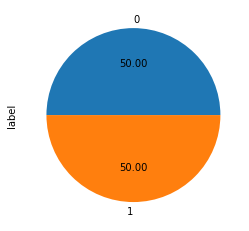

In [17]:
print(y_resampled.value_counts())
y_res.value_counts().plot.pie(autopct='%0.2f')

In [18]:
#X_res revert 2_dimensionality
X_resampled_1d = X_resampled.flatten()

# classification with resampled vectors
X_resampled_vect = classification.text2vec(X_resampled_1d, word_vectors)
X_resampled_vect_avg = classification.average_vector(X_resampled_vect)

In [19]:
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "Random Forest")
classification.print_classification_report(y_test, y_resampled_pred)
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_resampled_pred)
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "SVM")
classification.print_classification_report(y_test, y_resampled_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.60      0.86      0.71        51
    begnadet       0.59      0.26      0.36        39

    accuracy                           0.60        90
   macro avg       0.60      0.56      0.53        90
weighted avg       0.60      0.60      0.56        90

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.60      0.88      0.72        50
    begnadet       0.65      0.28      0.39        40

    accuracy                           0.61        90
   macro avg       0.62      0.58      0.55        90
weighted avg       0.62   